# Recurrent Neural Networks

# Case Study | Sentiment Analysis with IMDB Reviews

## 1. Preparing Our Colab for GPU Accelerated Training

In [1]:
import tensorflow as tf

# checking supporting GPU for tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## 2. TensorFlow Imports for Dataset Downloading

In [2]:
import tensorflow_datasets as tfds

# Dataset is a dictionary containing train, test, and unlabeled datasets
# Info contains relevant information about the dataset
dataset, info = tfds.load('imdb_reviews/subwords8k',with_info=True,as_supervised=True)

In [3]:
# Understanding the Bag-of-Word Concept: Text Encoding and Decoding

# Using info we can load the encoder which converts text to bag of words
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [4]:
# By using this encoder, we can encode new reviews:

# You can also encode a brand new comment with encode function
review = 'Terrible Movie!'
encoded_review = encoder.encode(review)
print('Encoded review is {}'.format(encoded_review))

Encoded review is [3585, 3194, 7785, 7962]


In [5]:
# You can easily decode an encoded review with decode function
original_review = encoder.decode(encoded_review)
print('The original review is "{}"'.format(original_review))

The original review is "Terrible Movie!"


## 3. Preparing the Dataset

In [6]:
# We can easily split our dataset dictionary with the relevant keys
train_dataset, test_dataset = dataset['train'], dataset['test']

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 4. Building the Recurrent Neural Network

In [7]:
# Imports for Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,Embedding,Bidirectional,Dropout,LSTM)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
__________________________________________________

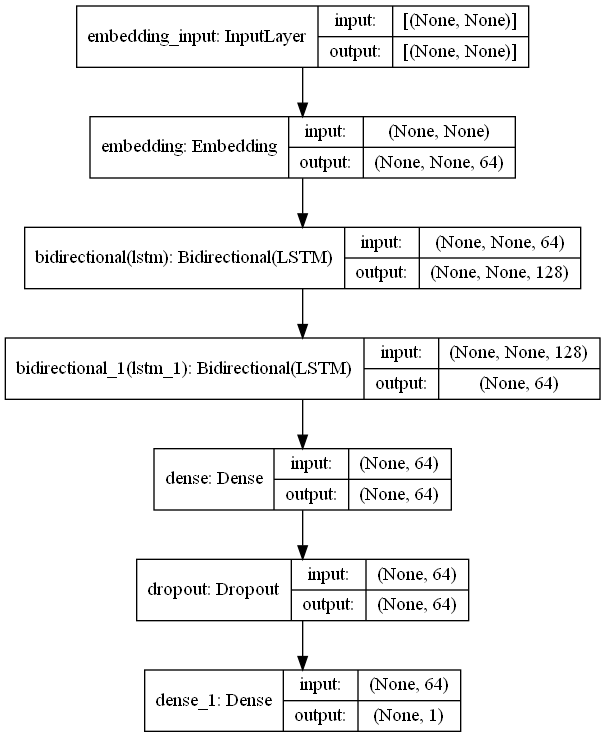

In [8]:
# Create the Model and Fill It with Layers

model = Sequential([Embedding(encoder.vocab_size, 64),
                    Bidirectional(LSTM(64, return_sequences=True)),
                    Bidirectional(LSTM(32)),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(1)])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compiling and Fitting the Model

model.compile(loss=BinaryCrossentropy(from_logits=True),optimizer=Adam(1e-4),metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
 17/391 [>.............................] - ETA: 1:07 - loss: 0.6932 - accuracy: 0.4806

## 5. Evaluating the Model

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# We can also use our history object to plot the performance measures over time with the following code:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy')

## 6. Making New Predictions

In [ ]:
# The following code is our custom padding function:
def review_padding(encoded_review, padding_size):
  zeros = [0] * (padding_size - len(encoded_review))
  encoded_review.extend(zeros)
  return encoded_review

# encoder function that would encode and process our review to feed into our trained model
def review_encoder(review):
  encoded_review = review_padding(encoder.encode( review ),64)
  encoded_review = tf.cast( encoded_review, tf.float32)
  return tf.expand_dims( encoded_review, 0)


In [ ]:
fight_club_review = 'It has some cliched moments, even for its time, but FIGHT CLUB is an awesome film. \
                     I have watched it about 100 times in the past 20 years. \
                     It never gets old. It is hard to discuss this film without giving things away but suffice it to say,\
                     it is a great thriller with some intriguing twists.'


In [ ]:
model.predict(review_encoder(fight_club_review))

## 7. Saving and Loading the Model

In [ ]:
# This will save the full model with its variables, weights, and biases.
model.save('/saved_model/sentiment_analysis')

# Also save the encoder for later use
encoder.save_to_file('/saved_model/sa_vocab')


## 8. Load the Trained Model and Make Predictions

### you can shut dowm this kernel, and then starting the followingcell.

In [ ]:
import tensorflow as tf

loaded = tf.keras.models.load_model("/saved_model/sentiment_analysis/")

In [ ]:
import tensorflow_datasets as tfds

vocab_path = '/saved_model/sa_vocab'
encoder = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_path)

In [ ]:
# The following code is our custom padding function:
def review_padding(encoded_review, padding_size):
  zeros = [0] * (padding_size - len(encoded_review))
  encoded_review.extend(zeros)
  return encoded_review

# encoder function that would encode and process our review to feed into our trained model
def review_encoder(review):
  encoded_review = review_padding(encoder.encode( review ),64)
  encoded_review = tf.cast( encoded_review, tf.float32)
  return tf.expand_dims( encoded_review, 0)


fight_club_review = 'It has some cliched moments, even for its time, but FIGHT CLUB is an awesome film. \
                     I have watched it about 100 times in the past 20 years. \
                     It never gets old. It is hard to discuss this film without giving things away but suffice it to say,\
                     it is a great thriller with some intriguing twists.'


In [ ]:
loaded.predict(review_encoder(rev))